## Requirements

Download GTZAN dataset

In [ ]:
!gdown --id 1gIm_aDWjHMEO6P0GEZ9jmy3kLcn0YXl5

Downloading...
From: https://drive.google.com/uc?id=1gIm_aDWjHMEO6P0GEZ9jmy3kLcn0YXl5
To: /content/genres.tar.gz
100% 1.23G/1.23G [00:11<00:00, 108MB/s] 


In [ ]:
!pip -q install pydub
!pip -q install torchaudio==0.7.0
!pip -q install xgboost

## Imports

In [ ]:
import os
import tqdm
import torch
import torchaudio
import tarfile
import librosa
import IPython
import matplotlib
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pydub import AudioSegment

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split

from torchaudio.datasets import GTZAN
from torchaudio.datasets.utils import download_url
from tensorflow import one_hot

import torchaudio.transforms as tt

%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
!tar -xvf genres.tar.gz

Set Download = flase because we have downloaded it already

In [ ]:
dataset = GTZAN(root=".", download=False)

In [ ]:
data_dir = '/content/genres'

In [ ]:
def getClasses(data_dir):
  list_files=os.listdir(data_dir)
  classes=[]
  for file in list_files:
    name='{}/{}'.format(data_dir,file)
    if os.path.isdir(name):
      classes.append(file)
  return classes

classes = getClasses(data_dir)
print(classes)

['metal', 'classical', 'country', 'disco', 'reggae', 'hiphop', 'rock', 'pop', 'blues', 'jazz']


In [ ]:
waveform1,samplerate1,label1 = dataset[0]
waveform2,samplerate2,label2 = dataset[111]

print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform1.size(),samplerate1,label1))
print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform2.size(),samplerate2,label2))

shape of waveform torch.Size([1, 661794]), sample rate with 22050, label is blues 
shape of waveform torch.Size([1, 661794]), sample rate with 22050, label is classical 


shape of spectogram torch.Size([1, 201, 3309])
shape of spectogram torch.Size([1, 201, 3309])


/usr/local/lib/python3.7/dist-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.7/dist-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


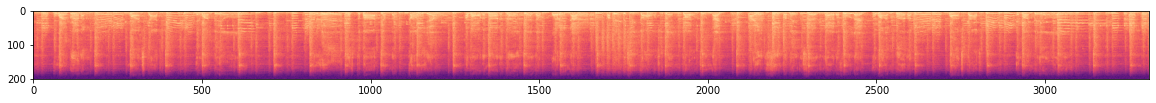

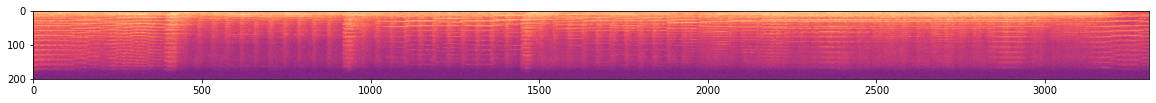

In [ ]:
specgram1=tt.Spectrogram()(waveform1)
print("shape of spectogram {}".format(specgram1.size()))
specgram2=tt.Spectrogram()(waveform2)
print("shape of spectogram {}".format(specgram2.size()))

plt.figure(figsize=(20, 5))
plt.imshow(specgram1.log2()[0,:,:].numpy(),cmap='magma')
plt.figure(figsize=(20, 5))
plt.imshow(specgram2.log2()[0,:,:].numpy(),cmap='magma')

In [ ]:
def createDirs(classes, new_dir):
  try:
    os.mkdir(new_dir)
    print("Directory " , new_dir ,  " Created ") 
  except FileExistsError:
    print("Directory " , new_dir,  " already exists...")
    
  for x in classes:
    directory_name='{}/{}'.format(new_dir,x)
    try:
        # Create  Directory  MyDirectory 
      os.mkdir(directory_name)
        #print if directory created successfully...
      print("Directory " , directory_name ,  " Created ") 
    except FileExistsError:
        ##print if directory already exists...
      print("Directory " , directory_name ,  " already exists...") 

new_dir='/content/data'
createDirs(classes, new_dir)

Directory  /content/data  Created 
Directory  /content/data/metal  Created 
Directory  /content/data/classical  Created 
Directory  /content/data/country  Created 
Directory  /content/data/disco  Created 
Directory  /content/data/reggae  Created 
Directory  /content/data/hiphop  Created 
Directory  /content/data/rock  Created 
Directory  /content/data/pop  Created 
Directory  /content/data/blues  Created 
Directory  /content/data/jazz  Created 


In [ ]:
def export_to_dir(class_name,new_dir,chopped_audio,counter):
  for audio_data in chopped_audio:
    file_name=class_name + '_' + str(counter)+'.wav'
    export_path=os.path.join(new_dir,file_name)
    audio_data.export(export_path, format="wav")
    int(counter)
    counter+=1  
  return counter  

def chop_audio(audio_file,segment_size,max_size):  #All file are not even so we cut it in same size using max_size and provide segment size using segment
  audio_data = AudioSegment.from_wav(audio_file)
  cut_audio_data = audio_data[:max_sec]
  chopped_audio=[x for x in cut_audio_data[::segment]]
  return chopped_audio

def parse_genres(fname):
    parts = fname.split('_')
    return ' '.join(parts[:-1])
  

In [ ]:
max_sec=30 * 1000 # max size of audio we take (for 30 sec)
segment=10 * 1000  # segment size(for 10 sec)
new_dir='/content/data'
counter=0

for x in classes:
  path=os.path.join("/content/genres", x)
  os.chdir(path)
  list_file=os.listdir(path)
  new_dir_genre = os.path.join(new_dir,x)
  for file_name in list_file:
    chopped_audio=chop_audio(file_name,segment,max_sec)
    counter=export_to_dir(x,new_dir_genre,chopped_audio,counter)

In [ ]:
print(os.getcwd())
print(len(chopped_audio))
print(counter)

/content/genres/jazz
3
3000


In [ ]:
os.chdir('/content')

## Feature Based Classification

In [ ]:
sample_rate = 22050
wnd_size = 2048 
wnd_stride = 512

In [ ]:
def extract_features(audio):
    chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sample_rate,n_fft=wnd_size,win_length=wnd_size, hop_length=wnd_size).flatten()
    rmse = librosa.feature.rms(y=audio, frame_length=wnd_size, hop_length=wnd_size).flatten()
    spec_cent = librosa.feature.spectral_centroid(y=audio, sr=sample_rate, n_fft=wnd_size, win_length=wnd_size, hop_length=wnd_stride).flatten()
    spec_bw = librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate,  n_fft=wnd_size, win_length=wnd_size, hop_length=wnd_stride).flatten()
    rolloff = librosa.feature.spectral_rolloff(y=audio + 0.01, sr=sample_rate,n_fft=wnd_size,win_length=wnd_size, hop_length=wnd_stride).flatten()
    zcr = librosa.feature.zero_crossing_rate(audio,frame_length=wnd_size, hop_length=wnd_stride).flatten()

    harmony = librosa.feature.tempogram(audio,win_length=wnd_size, hop_length=wnd_stride).flatten()

    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate,win_length=wnd_size, hop_length=wnd_stride)
    mfccs_features = np.hstack([np.mean(chroma_stft, axis=0),np.var(chroma_stft, axis=0),np.mean(rmse, axis=0),np.var(rmse, axis=0),np.mean(spec_cent, axis=0),
                                np.var(spec_cent, axis=0),np.mean(spec_bw, axis=0), np.var(spec_bw, axis=0),np.mean(rolloff, axis=0),np.var(rolloff, axis=0),
                                np.mean(zcr, axis=0),np.var(zcr, axis=0),np.mean(harmony, axis=0),
                                np.var(harmony, axis=0),np.mean(mfcc.T, axis=0),np.var(mfcc.T, axis=0)])
    return mfccs_features

In [ ]:
# from skimage.io import imsave
# class MusicDataset(Dataset):
#     def __init__(self, root):
#         super().__init__()
#         self.root = root
#         self.files = [fname for fname in os.listdir(root) if fname.endswith('.wav')]
#         self.classes = list(set(parse_genres(fname) for fname in self.files))
#         self.transform = tt.Spectrogram()
    
#     def __len__(self):
#         return len(self.files)

#     def __getitem__(self, i):
#         fname = self.files[i]
#         print((self.root, fname))
#         fpath = os.path.join(self.root, fname)
#         audio = torchaudio.load(fpath)[0]
#         print(len(audio[0]))
#         if len(audio[0]) <22050*10:
#             return
#         img = self.transform(audio)
#         img = img[:,:,:-1]
#         specgram = img.resize(1,img.size()[1]*2,img.size()[2]//2)
#         plt.figure(figsize=(6, 5))
#         plt.imshow(specgram.log2()[0,:,:].numpy(),cmap='magma')
#         plt.xlim([0, specgram.size()[2]])
#         plt.xticks([])
#         plt.yticks([])
#         img = np.squeeze(img,axis=0)
#         class_label = parse_genres(fname)

#         path_to_save = os.path.join('/content/data',class_label,fname+'.jpg')
#         plt.savefig(path_to_save)
#         from IPython.display import clear_output

#         clear_output(wait=True)
#         return audio, class_label

In [ ]:
class MusicDataset(Dataset):
    def __init__(self, root):
        super().__init__()
        self.root = root
        self.fpaths =  [fname for _,_,fname in os.walk(root) if fname]
        self.files = []
        for fname in self.fpaths:
          for f in fname:
            if f.endswith('.wav'):
              self.files.append(f)
        self.classes = list(set(parse_genres(fname) for fname in self.files))
        self.transform = extract_features
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]
        fpath = os.path.join(self.root,parse_genres(fname), fname)
        audio = librosa.load(fpath)[0]
        if len(audio) <22050*10:
            return
        feats = self.transform(audio)
        class_label = parse_genres(fname)
        return feats, class_label

In [ ]:
dataset = MusicDataset(new_dir)

In [ ]:
X=[]
y=[]
for d in tqdm.tqdm_notebook(dataset):
  if d is not None:
    X.append(d[0])
    y.append(d[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
print(f'{len(X)} samples in the dataset')

2991 samples in the dataset


In [ ]:
X = np.array(X)
y = np.array(y).reshape(-1,1)


data = np.hstack([X,y])

df = pd.DataFrame(data,columns = [i for i in range(X.shape[1])]+['labels'])

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,labels
0,0.46144622564315796,0.07522960007190704,0.10160871595144272,0.000573033990804106,2832.6375391143774,196847.62780853763,2263.8187824032425,58207.31284890073,5390.744974441705,778975.0555245113,0.17768905887470998,0.001732176964190618,0.138804445095263,0.046789240338786724,-77.52392578125,73.85814666748047,-41.365455627441406,55.42484664916992,-9.80247974395752,31.954145431518555,-12.055061340332031,25.33519172668457,-18.014402389526367,18.210519790649414,-19.190248489379883,8.154386520385742,-19.70462989807129,7.210487365722656,-7.31333589553833,5.648828983306885,-13.045845031738281,0.9245074391365051,-10.659893035888672,-3.224797487258911,710.5070190429688,371.31829833984375,224.6362762451172,100.1236572265625,85.25462341308594,65.97843170166016,79.69058990478516,46.136993408203125,52.952980041503906,46.562835693359375,32.863399505615234,25.680747985839844,43.38459777832031,52.336669921875,51.8391227722168,35.355587005615234,58.98509216308594,45.689964294433594,41.94163131713867,37.392372131347656,metal
1,0.4766130745410919,0.07637028396129608,0.2289465218782425,0.001316214445978403,3104.7489829970295,111595.28133083828,2400.2641974974813,46717.31651146831,5739.198165150087,424308.8090922569,0.19112075841067286,0.001240090073085835,0.12546565383280364,0.04123247191261647,8.072547912597656,63.252559661865234,-24.670534133911133,60.73622512817383,-17.253311157226562,27.876314163208008,-15.184203147888184,16.989316940307617,-11.549942970275879,17.296472549438477,-12.056083679199219,18.113773345947266,-10.671952247619629,13.801994323730469,-6.097410202026367,8.513005256652832,-8.020364761352539,3.4265623092651367,-9.153212547302246,7.387617111206055,533.3505859375,165.9094696044922,191.47012329101562,150.72190856933594,94.73235321044922,85.34974670410156,78.49769592285156,64.62848663330078,56.689414978027344,58.52682876586914,48.258995056152344,60.73588943481445,45.31845474243164,49.512001037597656,39.11819076538086,36.672698974609375,30.6164493560791,37.325138092041016,45.984344482421875,41.590415954589844,metal
2,0.4452823996543884,0.08122172951698303,0.09767501801252365,0.0006363874999806285,2630.8520847416175,255873.13246448472,2147.5486305082736,121863.11510524151,4949.514154491734,1187511.2871154416,0.14524724477958237,0.002035672737761592,0.08598316598990224,0.021632718980884848,-113.98417663574219,79.8329086303711,-40.311676025390625,73.17774963378906,-5.7354326248168945,25.543302536010742,-11.792083740234375,25.41423988342285,-16.527067184448242,13.163764953613281,-12.368885040283203,12.837336540222168,-12.48442268371582,4.414340019226074,-12.147810935974121,1.3768439292907715,-11.60632038116455,-1.0976660251617432,-3.7609047889709473,-3.6187710762023926,1502.40673828125,464.4570007324219,582.6034545898438,251.6705322265625,104.81188201904297,76.2742919921875,73.00941467285156,52.13746643066406,33.14680099487305,68.59139251708984,47.74797058105469,35.7255973815918,47.708980560302734,33.85920333862305,51.416934967041016,36.76054382324219,33.38540267944336,32.12893295288086,50.73306655883789,34.64799499511719,metal
3,0.5113515853881836,0.07688184082508087,0.2597420811653137,0.0020046511199325323,2714.041164662419,361388.80358389707,2502.3402385028066,98673.20197342015,5740.2473467408645,1183152.9067360982,0.11404935832366589,0.0016440468143121404,0.1354891362639974,0.04428778268412927,-15.57045841217041,75.54179382324219,-17.34221839904785,61.259315490722656,-3.0198211669921875,36.798919677734375,-7.87914514541626,32.37117004394531,-7.904566287994385,19.385074615478516,-10.67492961883545,14.872488021850586,-9.141741752624512,3.784259557723999,-7.325206279754639,5.338850021362305,-6.9914631843566895,1.1095904111862183,-2.709042549133301,1.7639429569244385,1450.586669921875,402.1274719238281,228.6114044189453,175.48089599609375,59.685699462890625,70.09046173095703,92

In [ ]:
df.to_csv('features_10sec.csv', index=None)

In [ ]:
!cp 'features_10sec.csv' /content/

cp: 'features_10sec.csv' and '/content/features_10sec.csv' are the same file


In [ ]:
def splitData(X,y,test_size=0.2, classes=10):
  mapping_dict = {y_:i for i,y_ in enumerate(classes)}
  X= np.array(X)
  y_categorical = [mapping_dict.get(y_) for y_ in y.ravel()]
  y_categorical = np.array(y_categorical)
  y_categorical = one_hot(y_categorical,len(classes),dtype=np.int32).numpy()

  X_train, X_test, y_train, y_test = train_test_split(X,y_categorical , test_size=test_size)
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = splitData(X, y, test_size=0.2, classes = classes)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((2392, 54), (599, 54), (2392, 10), (599, 10))

In [ ]:
def transformScale(X_train,X_test):
  mm_scaler = MinMaxScaler((-1,1))
  mm_scaler.fit(X_train)
  X_train_scaled = mm_scaler.transform(X_train)
  X_test_scaled = mm_scaler.transform(X_test)
  return X_train_scaled, X_test_scaled, mm_scaler

In [ ]:
X_train_scaled, X_test_scaled, mm_scaler = transformScale(X_train,X_test)

In [ ]:
y_train_new = np.argmax(y_train,axis=1)
y_test_new  = np.argmax(y_test,axis=1)

In [ ]:
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb.fit(X_train, y_train_new)
preds = xgb.predict(X_test)

Results for feature based method.

In [ ]:
cm = confusion_matrix(y_test_new, preds)
print('Accuracy:', round(accuracy_score(y_test_new, preds), 5), '\n')

Accuracy: 0.85643 



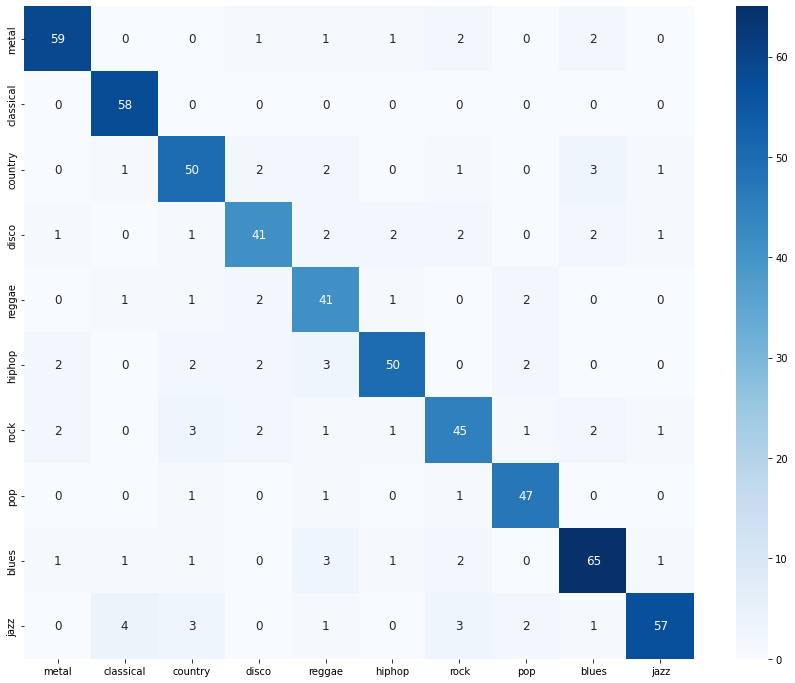

In [ ]:
df_cm = pd.DataFrame(cm,columns=classes, index=classes)
plt.figure(figsize = (15,12))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt='g', cmap='Blues')
plt.savefig('heatmap')

## CNN for Music Classification

In [ ]:
class MusicDataset(Dataset):
    def __init__(self, root):
        super().__init__()
        self.root = root
        self.fpaths =  [fname for _,_,fname in os.walk(root) if fname]
        self.files = []
        for fname in self.fpaths:
          for f in fname:
            if f.endswith('.wav'):
              self.files.append(f)
        self.classes = list(set(parse_genres(fname) for fname in self.files))
        self.max_len = 22050*10
        #self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        audio, class_idx = self.process(i)
        return audio, class_idx
        
    def process(self, i):
        fname = self.files[i]
        fpath = os.path.join(self.root,parse_genres(fname), fname)
        audio = torchaudio.load(fpath)[0]

        if audio.shape[1] < self.max_len:
            pad = np.zeros((self.max_len-audio.shape[1],1)).ravel()
            audio = np.hstack([audio[0],pad])
            audio = torch.FloatTensor(audio)
            audio = torch.unsqueeze(audio, dim=0)
            
        class_idx = self.classes.index(parse_genres(fname))
        return audio, class_idx

In [ ]:
dataset = MusicDataset(new_dir)
print(len(dataset))
dataset[0]


3000


(tensor([[-0.0047,  0.0135,  0.0172,  ...,  0.1613,  0.2242,  0.2332]]), 3)

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);
val_size = 600
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(2400, 600)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 16

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
for batch in train_dl:
  audio = batch[0]
  print(audio.shape)
  break

torch.Size([16, 1, 220500])


In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class MusicgenreClassificationBase(nn.Module):
    def training_step(self, batch):
        audios, labels = batch 
        out = self(audios)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        audios, labels = batch 
        out = self(audios)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

def conv_block1(in_channels, out_channels, pool=False):
    layers = [nn.Conv1d(in_channels, out_channels, kernel_size=11, padding=5), 
              nn.BatchNorm1d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool1d(100))
    return nn.Sequential(*layers)

def conv_block2(in_channels, out_channels, pool=False):
    layers = [nn.Conv1d(in_channels, out_channels, kernel_size=51, padding=30), 
              nn.BatchNorm1d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool1d(100))
    return nn.Sequential(*layers)

def conv_block3(in_channels, out_channels, pool=False):
    layers = [nn.Conv1d(in_channels, out_channels, kernel_size=101, padding=50), 
              nn.BatchNorm1d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool1d(100))
    return nn.Sequential(*layers)

In [ ]:

class MusicClassificationModel(MusicgenreClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block1(in_channels, 32,pool=True)
        self.conv2 = conv_block2(in_channels, 32,pool=True) 
        self.conv3 = conv_block3(in_channels, 32,pool=True)
        
        self.conv_1 = conv_block(3, 64)
        self.conv_2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))      
        self.conv_3 = conv_block(128, 256, pool=True)
        self.conv_4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))       
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2))
                                     
        self.linear1 = nn.Linear(34816, 2000)
        # output layer
        self.linear2 = nn.Linear(2000, 100)
        self.linear3 = nn.Linear(100, num_classes)

    def forward(self, xb):
        out1 = self.conv1(xb)
        out2 = self.conv2(xb)
        out3 = self.conv3(xb)
        out_new=torch.stack((out1,out2,out3),dim=1)
        out = self.conv_1(out_new)
        out = self.conv_2(out)
        out = self.res1(out) + out
        out = self.conv_3(out)
        out = self.conv_4(out)
        out = self.res2(out) + out
        out_1 = self.classifier(out)
        xb = out_1.view(out_1.size(0), -1)
        out= self.linear1(xb)
        out=F.relu(out)  
        out=self.linear2(out)
        out=F.relu(out)  
        out=self.linear3(out)
        return out

In [ ]:
model = to_device(MusicClassificationModel(1, 10), device)
model

MusicClassificationModel(
  (conv1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(11,), stride=(1,), padding=(5,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool1d(kernel_size=100, stride=100, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(1, 32, kernel_size=(51,), stride=(1,), padding=(30,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool1d(kernel_size=100, stride=100, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(1, 32, kernel_size=(101,), stride=(1,), padding=(50,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool1d(kernel_size=100, stride=100, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), s

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in tqdm.tqdm_notebook(range(epochs)):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
#%%time
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.10745613276958466, 'val_loss': 2.6992573738098145}]

In [ ]:
epochs = 20
max_lr = 0.005
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

This cell is optional, I ran it once and got 80% accuracy but the second time it did not optimize correctly and ended up overfitting, we can see val_loss>> train_loss. So may run it or may not run it

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.00041, train_loss: 0.6742, val_loss: 1.2819, val_acc: 0.5658
Epoch [1], last_lr: 0.00099, train_loss: 0.7304, val_loss: 1.2989, val_acc: 0.5938
Epoch [2], last_lr: 0.00185, train_loss: 0.7806, val_loss: 1.5527, val_acc: 0.5636
Epoch [3], last_lr: 0.00285, train_loss: 0.8250, val_loss: 1.7368, val_acc: 0.5219
Epoch [4], last_lr: 0.00380, train_loss: 0.9389, val_loss: 1.8492, val_acc: 0.5027
Epoch [5], last_lr: 0.00454, train_loss: 1.0585, val_loss: 1.7462, val_acc: 0.5493
Epoch [6], last_lr: 0.00495, train_loss: 1.0940, val_loss: 1.3689, val_acc: 0.5345
Epoch [7], last_lr: 0.00499, train_loss: 1.0353, val_loss: 1.4040, val_acc: 0.5378
Epoch [8], last_lr: 0.00491, train_loss: 0.8661, val_loss: 2.4970, val_acc: 0.5005
Epoch [9], last_lr: 0.00475, train_loss: 0.8426, val_loss: 1.4767, val_acc: 0.5789
Epoch [10], last_lr: 0.00452, train_loss: 0.8046, val_loss: 1.7747, val_acc: 0.5334
Epoch [11], last_lr: 0.00423, train_loss: 0.6055, val_loss: 1.4326, val_acc: 0.6124
Ep

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

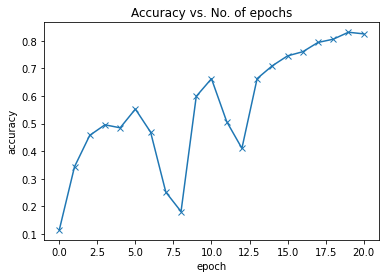

In [ ]:
plot_accuracies(history)


In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

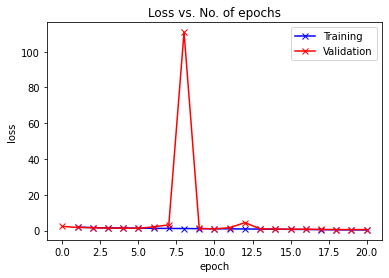

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

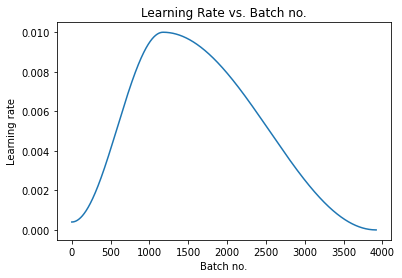

In [ ]:
plot_lrs(history)


In [ ]:
def load_gtzan_item(fileid: str, path: str, ext_audio: str):
    """
    Loads a file from the dataset and returns the raw waveform
    as a Torch Tensor, its sample rate as an integer, and its
    genre as a string.
    """
    # Filenames are of the form label.id, e.g. blues.00078
    label, _ = fileid.split(".")

    # Read wav
    file_audio = os.path.join(path, label, fileid + ext_audio)
    waveform, sample_rate = torchaudio.load(file_audio)

    return waveform, sample_rate, label
class TestDataset(GTZAN):
   def __getitem__(self, n: int):
        fileid = self._walker[n]
        item = load_gtzan_item(fileid, self._path, self._ext_audio)
        waveform, sample_rate, label = item
        label = classes.index(label)
        return waveform, label

In [ ]:
#test_dataset = TestDataset(root=".", download=False)


In [ ]:
#test_dataset[0]


In [ ]:
test_dl = DataLoader(val_ds,1,shuffle=True, num_workers=4, pin_memory=True)
test_dl=DeviceDataLoader(test_dl,device)

In [ ]:
def predict_audio(audio, model):
    # Convert to a batch of 1
    xb = audio
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]
actuals=[]
predictions=[]
for audio,label in test_dl:
  # print("Actual label: {}".format(classes[label[0].item()]))
  # print( 'Predicted Label: ', predict_audio(audio, model))
  actuals.append(classes[label[0].item()])
  predictions.append(predict_audio(audio, model))

This is the result for neural network based method.

In [ ]:
print(classification_report(actuals,predictions))

              precision    recall  f1-score   support

       blues       0.86      0.79      0.82       150
   classical       0.89      0.83      0.86       141
     country       0.78      0.88      0.83       139
       disco       0.84      0.79      0.81       150
      hiphop       0.88      0.91      0.90       159
        jazz       0.72      0.74      0.73       141
       metal       0.84      0.85      0.84       145
         pop       0.72      0.68      0.70       148
      reggae       0.82      0.83      0.83       170
        rock       0.88      0.93      0.90       157

    accuracy                           0.82      1500
   macro avg       0.82      0.82      0.82      1500
weighted avg       0.82      0.82      0.82      1500



In [ ]:
saved_path = '/content/music_model.pt' 

In [ ]:
torch.save(model.state_dict(),saved_path)

In [ ]:
music_dict = torch.load(saved_path)
music_model = to_device(multitemporalfeturemap(1, 10), device)
music_model.load_state_dict(music_dict)

<All keys matched successfully>

In [ ]:
for audio,label in test_dl:
  print("Actual label: {}".format(classes[label[0].item()]))
  print( 'Predicted Label: ', predict_audio(audio, music_model))
  break

Actual label: classical
Predicted Label:  disco


In [ ]:
for audio,label in test_dl:
  print("Actual label: {}".format(classes[label[0].item()]))
  print( 'Predicted Label: ', predict_audio(audio, music_model))
  break

Actual label: reggae
Predicted Label:  reggae


In [ ]:
for audio,label in test_dl:
  print("Actual label: {}".format(classes[label[0].item()]))
  print( 'Predicted Label: ', predict_audio(audio, music_model))
  break

Actual label: country
Predicted Label:  disco


In [ ]:
for audio,label in test_dl:
  print("Actual label: {}".format(classes[label[0].item()]))
  print( 'Predicted Label: ', predict_audio(audio, music_model))
  break

Actual label: pop
Predicted Label:  disco


In [ ]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=956173393737b666720bdee5958716ffef1d9207a05531fe772ea7310ce2831d
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [ ]:
x = dataset[0][0].unsqueeze(dim=0).to(device)
y = model(x)


/usr/local/lib/python3.7/dist-packages/torchviz/dot.py:68: UserWarning: make_dot: showing grad_fn attributes and saved variables requires PyTorch version >= 1.9. (This does NOT apply to saved tensors saved by custom autograd functions.)
  "make_dot: showing grad_fn attributes and saved variables"


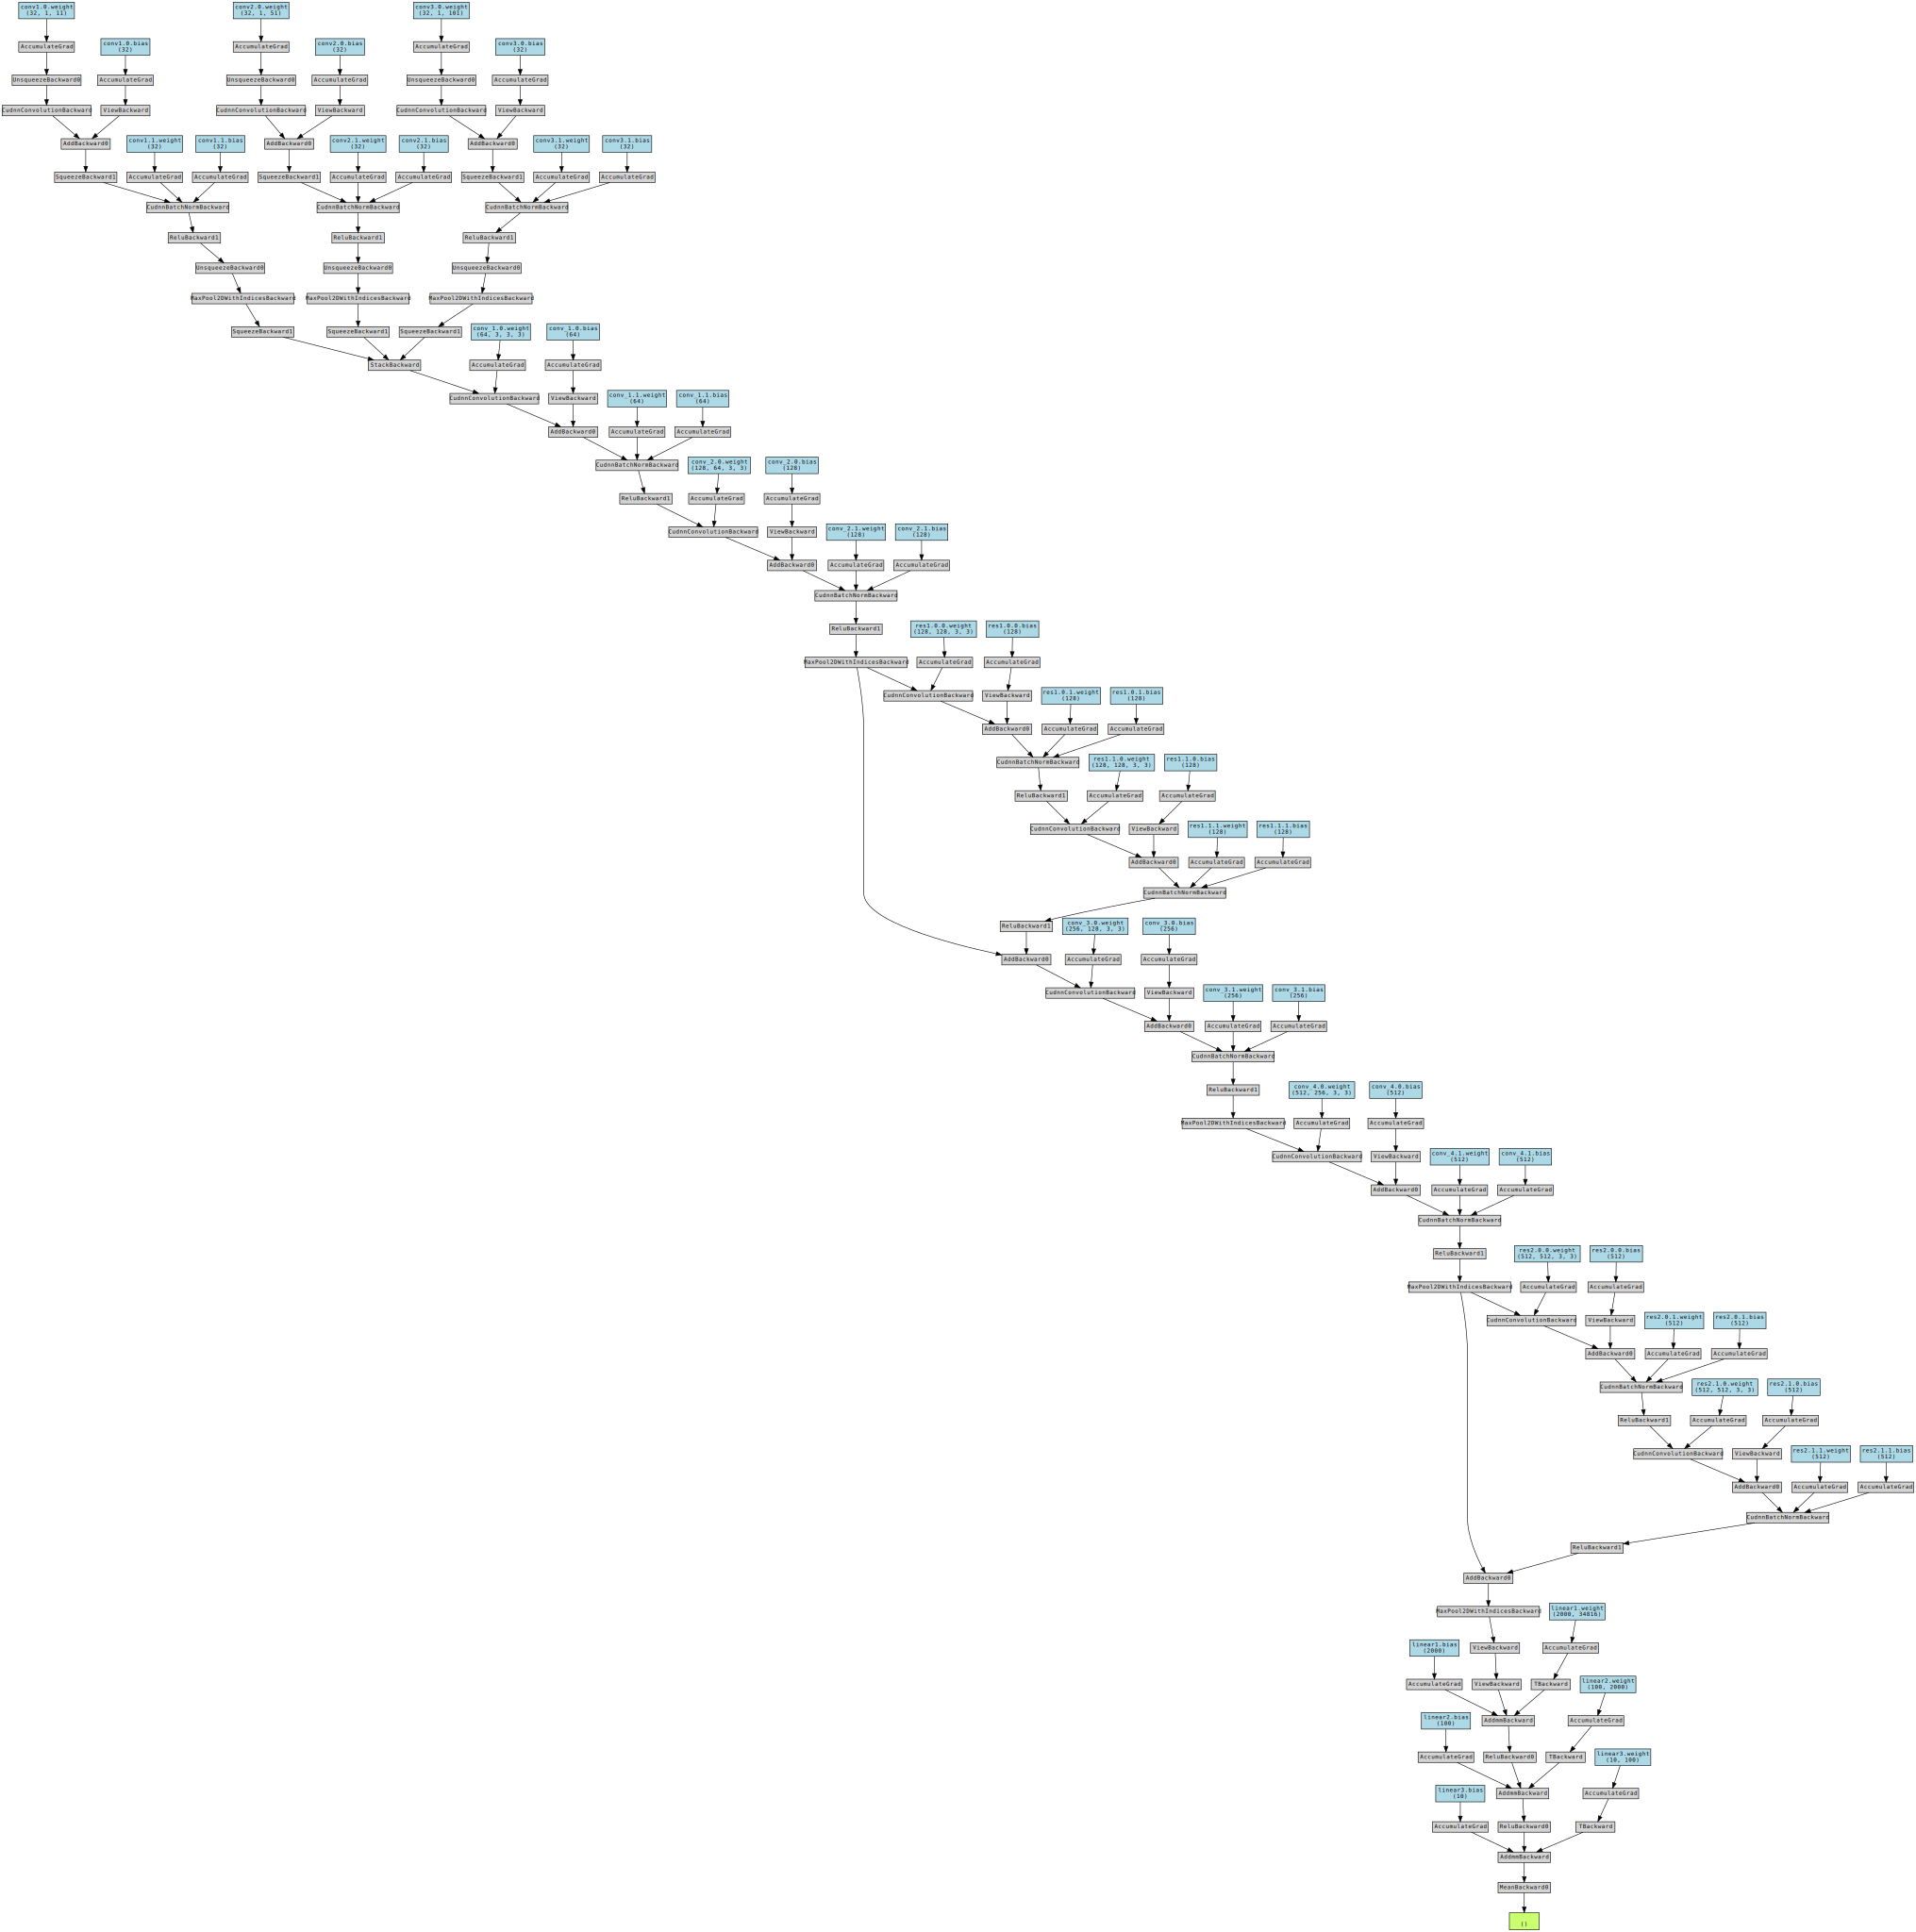

In [ ]:
from torchviz import make_dot
make_dot(y.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)